In [3]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
import os
import tensorflow as tf
from IPython import display
from sklearn import metrics
import glob
import sys
from riotwatcher import RiotWatcher
import requests
import json

api_file = os.path.join('..','..','apikeys','LOL_api_key.txt')
with open(api_file, 'r') as fin:
    watcher = RiotWatcher(fin.readline())

tf.logging.set_verbosity(tf.logging.ERROR)

### Get all champs in game from static data file (.json)

In [4]:
champfile=os.path.join('lol_data','version6.24.1_champion.json')
with open(champfile,'r') as fin:
    champdata=json.load(fin)

In [5]:
champ_vocab=[]
for name,data in champdata['data'].items():
    champ_vocab.append(data['key'])
champ_vocab = [int(i) for i in champ_vocab]

# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline

In [6]:
def _parse_function_win(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "blue_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "red_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8-bit ints for heroes
        "targets": tf.FixedLenFeature(shape=[1], dtype=tf.int64)
                }
  
    parsed_features = tf.parse_single_example(record, features)
  
    blue_champs = tf.decode_raw(parsed_features['blue_champs'], tf.int64)
    red_champs = tf.decode_raw(parsed_features['red_champs'], tf.int64)
    target = parsed_features['targets']

    return  {'blue_champs':blue_champs, 'red_champs':red_champs}, target

In [7]:
def _parse_function_float(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "blue_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "red_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8-bit ints for heroes
        "targets": tf.FixedLenFeature(shape=[1], dtype=tf.float32)
                }
  
    parsed_features = tf.parse_single_example(record, features)
  
    blue_champs = tf.decode_raw(parsed_features['blue_champs'], tf.int64)
    red_champs = tf.decode_raw(parsed_features['red_champs'], tf.int64)
    target = parsed_features['targets']

    return  {'blue_champs':blue_champs, 'red_champs':red_champs}, target

#### Check the parse function worked

In [8]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('LOL_data','mix_tier',
                                          'lol_training_data',
                                          'blue_win_lol_training_data.tfrecords'))
# Map features and labels with the parse function.
ds = ds.map(_parse_function_win)

ds

<DatasetV1Adapter shapes: ({blue_champs: (?,), red_champs: (?,)}, (1,)), types: ({blue_champs: tf.int64, red_champs: tf.int64}, tf.int64)>

In [9]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'blue_champs': array([157, 222, 120, 163,  12]),
  'red_champs': array([ 59,  13,   7,  29, 117])},
 array([0]))

## Model Functions

In [6]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn_win(input_filenames, num_epochs=None, shuffle=True, batch_size=50):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function_win)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(batch_size, ds.output_shapes)
  
    ds = ds.repeat(num_epochs)
  
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [7]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn_gold(input_filenames, num_epochs=None, shuffle=True, batch_size=50):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function_float)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(batch_size, ds.output_shapes)
  
    ds = ds.repeat(num_epochs)
  
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Linear model with vocabulary (all champions)

In [8]:
def construct_hero_categorical_columns(keys,vocab):
    """Construct categorical features for all features
        Args: 
            input_features: names of input feature columns to use
        returns:
            a set of categorical columns
    """
    return set([tf.feature_column.categorical_column_with_vocabulary_list(key,
                                                                     vocabulary_list = vocab,
                                                                     num_oov_buckets =0)
                                    for key in keys])
                                                               

## Define and train the linear model

In [41]:
def train_linear_model(
    target,
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_file,
    test_file):
    """Trains a linear regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        target: Target to use for the model (determines whether float and classifier
          vs regressor)
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `LinearEstimator` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods
    if target=='blue_win':
        head=tf.contrib.estimator.binary_classification_head()
    else:
        head=tf.contrib.estimator.regression_head()

    
    # Create a linear regressor object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    linear_estimator = tf.estimator.LinearEstimator(
      head=head,
      feature_columns=feature_columns,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
      )
    if target=='blue_win':
        training_input_fn =lambda: _input_fn_win([training_file])
        test_input_fn =lambda: _input_fn_win([test_file])
    else:
        training_input_fn =lambda: _input_fn_gold([training_file])
        test_input_fn =lambda: _input_fn_gold([test_file])

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_acc = []
    test_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        linear_estimator.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = linear_estimator.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_acc.append(evaluation_metrics['loss'])
                            
        evaluation_metrics = linear_estimator.evaluate(
            input_fn=test_input_fn,
            steps=steps_per_period)    
        test_acc.append(evaluation_metrics['loss'])
        
        print('test loss', evaluation_metrics['loss'])

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_acc,label='Training loss')
    plt.plot(test_acc,label='Test loss')
    plt.legend()
    plt.show()
    
    return linear_estimator


### Train a binary classification model for blue_win

Training model...
test loss 0.69206125
test loss 0.6916218
test loss 0.69135606
test loss 0.691121
test loss 0.6909457
test loss 0.69085747
test loss 0.6906866
test loss 0.69061834
test loss 0.6905373
test loss 0.6904901
test loss 0.69043005
test loss 0.6903615
test loss 0.6903282
test loss 0.69031125
test loss 0.690244
test loss 0.69023037
test loss 0.6901719
test loss 0.6901614
test loss 0.69012135
test loss 0.69011706
Test set metrics:
accuracy 0.53044343
accuracy_baseline 0.5049286
auc 0.5452918
auc_precision_recall 0.5311785
average_loss 0.69011754
label/mean 0.49507144
loss 0.69011706
precision 0.5305559
prediction/mean 0.49344492
recall 0.44743603
global_step 50000
---


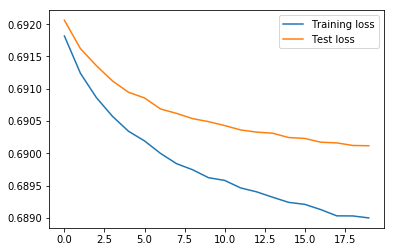

In [64]:
training_file = os.path.join('lol_data','mix_tier','lol_training_data','blue_win_lol_training_data.tfrecords')
test_file = os.path.join('lol_data','mix_tier','lol_test_data','blue_win_lol_test_data.tfrecords')

trained_win_linear_model = train_linear_model(
    target='blue_win',
    learning_rate=0.003,
    steps=5e4,
    batch_size=2000,
    feature_columns=construct_hero_categorical_columns(['blue_champs','red_champs'],
                                                       champ_vocab),
    training_file=training_file,
    test_file=test_file)

### Train a linear regression model for gold_diff

Training model...
test loss 0.9842289
test loss 0.9836467
test loss 0.9834102
test loss 0.98333055
test loss 0.9831264
test loss 0.98310876
test loss 0.98323774
test loss 0.98304826
test loss 0.98312145
test loss 0.98305404
test loss 0.98301
test loss 0.9831802
test loss 0.98302025
test loss 0.98302937
test loss 0.98306865
test loss 0.9828882
test loss 0.98304987
test loss 0.9830139
test loss 0.98297536
test loss 0.98316056
Test set metrics:
average_loss 0.98316014
label/mean 0.00010354905
loss 0.98316056
prediction/mean -0.00010493766
global_step 500000
---


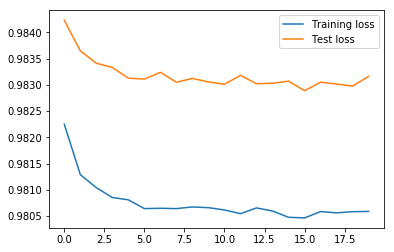

In [103]:
training_file = os.path.join('lol_data','mix_tier','lol_training_data',
                             'gold_diff_lol_training_data.tfrecords')
test_file = os.path.join('lol_data','mix_tier','lol_test_data',
                         'gold_diff_lol_test_data.tfrecords')

trained_gold_linear_model = train_linear_model(
    target='gold_diff',
    learning_rate=0.004,
    steps=50e4,
    batch_size=2000,
    feature_columns=construct_hero_categorical_columns(['blue_champs','red_champs'],champ_vocab),
    training_file=training_file,
    test_file=test_file)

### Validate model
only do this if you're done training!!

In [74]:
validation_file = os.path.join('lol_data','mix_tier',
                               'lol_validation_data',
                               'gold_diff_lol_validation_data.tfrecords')
validation_input_fn =lambda: _input_fn_gold([validation_file])
evaluation_metrics = trained_gold_linear_model.evaluate(
            input_fn=validation_input_fn,
            steps=100)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

average_loss 0.9709904
label/mean 0.0017768231
loss 0.97099054
prediction/mean -0.0011792702
global_step 500000


## Define and train a DNN model

### Define feature column constructor functions

In [75]:
def construct_indicator_columns(feature_columns):
    """Construct indicator columns for all features
            from categorical columns
        Args: 
            feature_columns: Set of 'tf.feature_column.categorical_column'
                to convert to indicator columns
        returns:
            a list of indicator columns
    """
    indicator_columns = []
    for column in list(feature_columns):
        indicator_columns.append(tf.feature_column.indicator_column(column))
        
    return indicator_columns
        

In [76]:
def construct_embedding_columns(feature_columns, dimension):
    """Construct embedding columns for all features
            from categorical columns
        Args:
            feature_columns: `Set` of 'tf.feature_column.categorical_column'
                to convert to embedding columns
            dimension: `int` that shows the 
        returns:
            a list of embedding columns
    """
            
    embedding_columns = []
    for column in list(feature_columns):
        embedding_columns.append(tf.feature_column.embedding_column(column,dimension=dimension))
        
    return embedding_columns

### Define model training function

In [77]:
def train_dnn_model(
    target,
    my_optimizer,
    hidden_units,
    steps,
    batch_size,
    feature_columns,
    training_file,
    test_file):
    """Trains a deep neural network regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        target: A `str` specifying the target.
        my_optimizer: A `tf.Optimizer` to use to train our model
        hidden_units: A `list` of `ints` specifying the number of layers and number 
            of nodes per layer.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: `int` specifying the batch size.
        feature_columns: A `set` specifying the input feature columns to use.
        training_file: A 'string' specifying the training data file location
        test_file: A `string` specifying the test data file location
      
    Returns:
        A `DNNClassifer` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods
    
    if target=='blue_win':
        head=tf.contrib.estimator.binary_classification_head()
    else:
        head=tf.contrib.estimator.regression_head()

    # Create a dnn regressor object.
    dnn_estimator = tf.estimator.DNNEstimator(
      head=head,
      feature_columns=feature_columns,
      hidden_units=hidden_units,
      optimizer=my_optimizer
      )
  
    if target=='blue_win':
        training_input_fn =lambda: _input_fn_win([training_file])
        test_input_fn =lambda: _input_fn_win([test_file])
    else:
        training_input_fn =lambda: _input_fn_gold([training_file])
        test_input_fn =lambda: _input_fn_gold([test_file])

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_acc = []
    test_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        dnn_estimator.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = dnn_estimator.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_acc.append(evaluation_metrics['loss'])
        #print('training accuracy %f' %(evaluation_metrics['accuracy'])) 
        
        evaluation_metrics = dnn_estimator.evaluate(
            input_fn=test_input_fn,
            steps=steps_per_period)    
        test_acc.append(evaluation_metrics['loss'])
        
        print('test accuracy %f' %(evaluation_metrics['loss']))

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_acc,label='Training loss')
    plt.plot(test_acc,label='Test loss')
    plt.legend()
    plt.show()
    
    return dnn_estimator


### Specify path to tfrecord files and construct feature colums

In [63]:
training_file_win = os.path.join('lol_data','mix_tier','lol_training_data',
                             'blue_win_lol_training_data.tfrecords')
test_file_win = os.path.join('lol_data','mix_tier','lol_test_data',
                         'blue_win_lol_test_data.tfrecords')

training_file_gold = os.path.join('lol_data','mix_tier','lol_training_data',
                             'gold_diff_lol_training_data.tfrecords')
test_file_gold = os.path.join('lol_data','mix_tier','lol_test_data',
                         'gold_diff_lol_test_data.tfrecords')

categorical_feature_columns = construct_hero_categorical_columns(['blue_champs','red_champs'],champ_vocab)
indicator_feature_columns = construct_indicator_columns(categorical_feature_columns)
embedding_feature_columns = construct_embedding_columns(categorical_feature_columns,dimension=4)

### Train model for blue_win

Training model...
test accuracy 0.692736
test accuracy 0.690703
test accuracy 0.690700
test accuracy 0.690560
test accuracy 0.690635
test accuracy 0.690531
test accuracy 0.690387
test accuracy 0.690536
test accuracy 0.690765
test accuracy 0.690347
test accuracy 0.690621
test accuracy 0.690694
test accuracy 0.690713
test accuracy 0.691131
test accuracy 0.690605
test accuracy 0.690638
test accuracy 0.690800
test accuracy 0.690560
test accuracy 0.690909
test accuracy 0.690578
Test set metrics:
accuracy 0.53137624
accuracy_baseline 0.5054605
auc 0.5431834
auc_precision_recall 0.53000677
average_loss 0.69057864
label/mean 0.4945395
loss 0.69057775
precision 0.5295936
prediction/mean 0.49553642
recall 0.46889746
global_step 60000
---


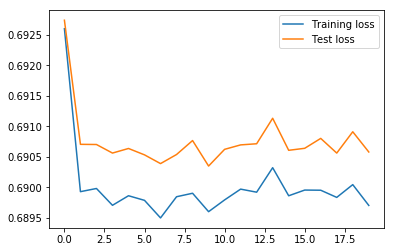

In [98]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0005, learning_rate=0.0009)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

trained_dnn_model = train_dnn_model(
    target = 'blue_win',
    my_optimizer = my_optimizer,
    hidden_units = [16,16],
    steps=6e4,
    batch_size=3000,
    feature_columns=embedding_feature_columns,
    training_file=training_file_win,
    test_file=test_file_win)

### Train model for gold_diff

Training model...
test accuracy 0.993505
test accuracy 0.986219
test accuracy 0.984541
test accuracy 0.983805
test accuracy 0.983313
test accuracy 0.984296
test accuracy 0.983490
test accuracy 0.984584
test accuracy 0.983483
test accuracy 0.983216
test accuracy 0.983471
test accuracy 0.983219
test accuracy 0.983500
test accuracy 0.983657
test accuracy 0.983689
test accuracy 0.983752
test accuracy 0.983711
test accuracy 0.983538
test accuracy 0.984153
test accuracy 0.983420
Test set metrics:
average_loss 0.9834413
label/mean -8.640563e-05
loss 0.98342013
prediction/mean 0.009866235
global_step 300000
---


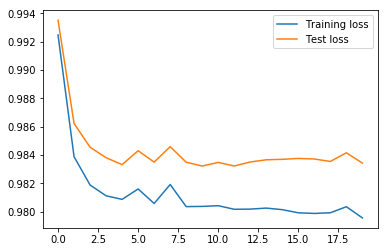

In [85]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=20e-6, learning_rate=2e-4)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

trained_dnn_model = train_dnn_model(
    target = 'gold_diff',
    my_optimizer = my_optimizer,
    hidden_units = [24,24],
    steps=3e5,
    batch_size=3000,
    feature_columns=embedding_feature_columns,
    training_file=training_file_gold,
    test_file=test_file_gold)

### Validate model
only do this if you're done training!!

In [24]:
validation_file = os.path.join('LOL_data','masters_tier','lol_validation_data', 'lol_validation_data.tfrecords')
validation_input_fn =lambda: _input_fn([validation_file])
evaluation_metrics = trained_dnn_model.evaluate(
            input_fn=validation_input_fn,
            steps=3e3)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

accuracy 0.5495492
accuracy_baseline 0.50042677
auc 0.5685406
auc_precision_recall 0.5591297
average_loss 0.6860394
label/mean 0.50042677
loss 34.295567
precision 0.5458012
prediction/mean 0.507441
recall 0.5950433
global_step 3000


### Investigate embeding layer

In [99]:
champ_list = interface('IEconDOTA2_570').GetHeroes(itemizedonly = True)['result']['heroes']

NameError: name 'interface' is not defined

In [100]:
vocab = list(range(105))+list(range(106,114))+list(range(119,121))
red_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/red_champs_embedding/embedding_weights')

blue_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/blue_heroes_embedding/embedding_weights')

for champ_index in range(len(vocab)):
    # Create a one-hot encoding for our term. It has 0s everywhere, except for
    # a single 1 in the coordinate that corresponds to that term.
    red_vector = np.zeros(len(vocab))
    red_vector[champ_index] = 1
    blue_vector = np.zeros(len(vocab))
    blue_vector[champ_index] = 1
    # We'll now project that one-hot vector into the embedding space.
    red_embedding_xy = np.matmul(dire_vector, dire_embedding_matrix)
    blue_embedding_xy = np.matmul(dire_vector,dire_embedding_matrix)
    #plt.text(dire_embedding_xy[0],
    #       dire_embedding_xy[1],
    #       hero_list[hero_index]['name'][14:],fontsize=8)
    plt.text(blue_embedding_xy[0],
           blue_embedding_xy[3],
           champ_list[champ_index]['name'][14:],fontsize=8,)

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * red_embedding_matrix.min(), 1.2 * red_embedding_matrix.max())
plt.ylim(1.2 * red_embedding_matrix.min(), 1.2 * red_embedding_matrix.max())
plt.show() 

NotFoundError: Key dnn/input_from_feature_columns/input_layer/blue_heroes_embedding/embedding_weights not found in checkpoint

### Save a trained model later exploration, or for on-demand prediction of test cases

In [104]:
def serving_input_receiver_fn():
    """An input receiver that expects a serialized tf.Example."""
    feature_spec = {
        "blue_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "red_champs": tf.FixedLenFeature([], dtype=tf.string) #array of five 8-bit ints for heroes
                }
    serialized_tf_example = tf.placeholder(dtype=tf.string,
                                         shape=[1],
                                         name='input_example_tensor')
    receiver_tensors = {'examples': serialized_tf_example}
    parsed_features = tf.parse_example(serialized_tf_example, feature_spec)
    
    radiant_heroes = tf.decode_raw(parsed_features['blue_champs'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['red_champs'], tf.int64)
    
    features = {'blue_champs':radiant_heroes, 'red_champs': dire_heroes}
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [105]:
export_dir = os.path.join('trained_models','linear_models')
trained_gold_linear_model.export_savedmodel(
                                export_dir_base = export_dir,
                                serving_input_receiver_fn = serving_input_receiver_fn)

b'trained_models/linear_models/1560113732'